# ASL 수어 분류 - nn.Linear 모델

CSV 파일로 된 ASL(American Sign Language) 데이터셋을 다층 nn.Linear 모델로 분류하는 PyTorch 딥러닝 프로젝트

## 데이터셋 정보
- **훈련 데이터**: sign_mnist_train.csv (27,455개 샘플)
- **검증 데이터**: sign_mnist_valid.csv
- **이미지 크기**: 28x28 픽셀 (784개 특징)
- **클래스 수**: 24개 (A-Z에서 J와 Z 제외)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

from sklearn.metrics import confusion_matrix, classification_report
from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'사용 디바이스: {device}')

사용 디바이스: cuda


In [2]:
import matplotlib.font_manager as fm

def setup_korean_font():
    try:
        font_list = [f.name for f in fm.fontManager.ttflist]
        korean_fonts = ['Malgun Gothic', 'NanumGothic', 'NanumBarunGothic', 'AppleGothic']
        
        for font in korean_fonts:
            if font in font_list:
                plt.rcParams['font.family'] = font
                print(f'한글 폰트 설정: {font}')
                break
        else:
            print('한글 폰트를 찾을 수 없습니다. 기본 폰트 사용')
        
        plt.rcParams['axes.unicode_minus'] = False
    except Exception as e:
        print(f'폰트 설정 오류: {e}')

setup_korean_font()

한글 폰트 설정: Malgun Gothic


## 1. CSV 데이터 로드 및 탐색

In [11]:
train_csv_path = './data/asl_data/sign_mnist_train.csv'
test_csv_path = './data/asl_data/sign_mnist_valid.csv'

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

print(f'훈련 데이터 크기: {train_df.shape}')
print(f'테스트 데이터 크기: {test_df.shape}')
print(f'\n컬럼 정보:')
print(train_df[train_df.columns.tolist()[:10]].head())

훈련 데이터 크기: (27455, 785)
테스트 데이터 크기: (7172, 785)

컬럼 정보:
   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      3     107     118     127     134     139     143     146     150   
1      6     155     157     156     156     156     157     156     158   
2      2     187     188     188     187     187     186     187     188   
3      2     211     211     212     212     211     210     211     210   
4     12     164     167     170     172     176     179     180     184   

   pixel9  
0     153  
1     158  
2     187  
3     210  
4     185  


클래스 분포:
label
0     1126
1     1010
2     1144
3     1196
4      957
5     1204
6     1090
7     1013
8     1162
9     1114
10    1241
11    1055
12    1151
13    1196
14    1088
15    1279
16    1294
17    1199
18    1186
19    1161
20    1082
21    1225
22    1164
23    1118
Name: count, dtype: int64


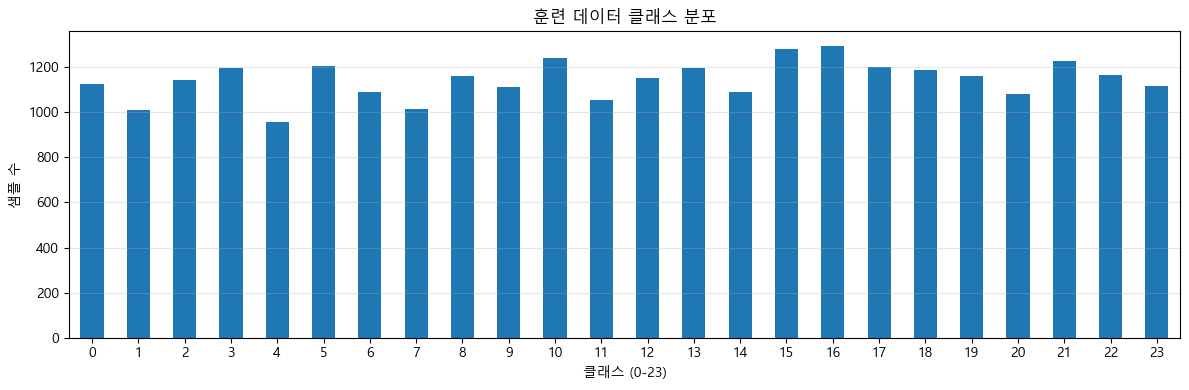

In [4]:
print('클래스 분포:')
print(train_df['label'].value_counts().sort_index())

plt.figure(figsize=(12, 4))
train_df['label'].value_counts().sort_index().plot(kind='bar')
plt.title('훈련 데이터 클래스 분포')
plt.xlabel('클래스 (0-23)')
plt.ylabel('샘플 수')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

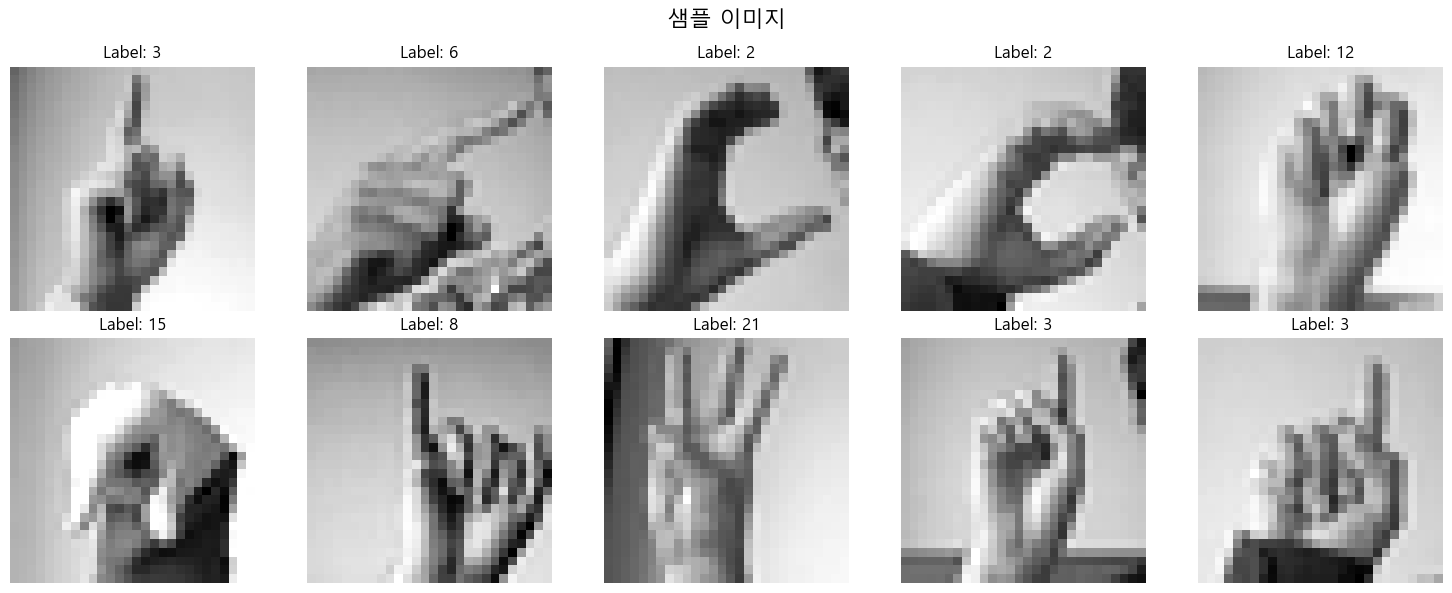

In [12]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i in range(10):
    sample = train_df.iloc[i]
    label = sample['label']
    pixels = sample[1:].values.reshape(28, 28)
    
    axes[i].imshow(pixels, cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.suptitle('샘플 이미지', fontsize=16)
plt.tight_layout()
plt.show()

## 2. Custom Dataset 클래스 정의 및 데이터 증강

In [13]:
class ASLCSVDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        label = int(row['label'])
        pixels = row[1:].values.astype(np.float32).reshape(28, 28)
        
        image = Image.fromarray(pixels.astype(np.uint8), mode='L')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [14]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

print('데이터 증강 설정 완료')

데이터 증강 설정 완료


## 3. DataLoader 생성

In [15]:
full_train_dataset = ASLCSVDataset(train_csv_path, transform=train_transform)
test_dataset = ASLCSVDataset(test_csv_path, transform=val_transform)

train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

print(f'훈련 데이터: {len(train_dataset)}개')
print(f'검증 데이터: {len(val_dataset)}개')
print(f'테스트 데이터: {len(test_dataset)}개')

훈련 데이터: 21964개
검증 데이터: 5491개
테스트 데이터: 7172개


In [16]:
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f'배치 크기: {batch_size}')
print(f'훈련 배치 수: {len(train_loader)}')
print(f'검증 배치 수: {len(val_loader)}')
print(f'테스트 배치 수: {len(test_loader)}')

배치 크기: 128
훈련 배치 수: 172
검증 배치 수: 43
테스트 배치 수: 57


## 4. 다층 nn.Linear 모델 정의

In [17]:
class ASLLinearNet(nn.Module):
    def __init__(self, input_size=784, num_classes=24):
        super(ASLLinearNet, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.2)
        
        self.fc4 = nn.Linear(128, num_classes)
        
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        
        x = self.fc4(x)
        
        return x

model = ASLLinearNet().to(device)
print(model)
print(f'\n총 파라미터 수: {sum(p.numel() for p in model.parameters()):,}')

ASLLinearNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=128, out_features=24, bias=True)
  (relu): ReLU()
)

총 파라미터 수: 571,032


## 5. 학습 루프 (Train/Validation)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

print('Loss 함수: CrossEntropyLoss')
print('Optimizer: Adam (lr=0.001)')
print('Scheduler: ReduceLROnPlateau')

Loss 함수: CrossEntropyLoss
Optimizer: Adam (lr=0.001)
Scheduler: ReduceLROnPlateau


f:\Anaconda3\envs\torch_env_113\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [19]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100*correct/total:.2f}%'})
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validation', leave=False):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

print('학습 및 검증 함수 정의 완료')

학습 및 검증 함수 정의 완료


In [20]:
num_epochs = 5
best_val_acc = 0.0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print(f'학습 시작 (총 {num_epochs} 에포크)\n')

for epoch in range(num_epochs):
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    scheduler.step(val_loss)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        os.makedirs('./model', exist_ok=True)
        torch.save(model.state_dict(), './model/best_nnLinear_model.pth')
        print(f'✓ 최고 성능 모델 저장 (Val Acc: {val_acc:.2f}%)')
    
    print('-' * 60)

print(f'\n학습 완료! 최고 검증 정확도: {best_val_acc:.2f}%')

학습 시작 (총 5 에포크)

Epoch [1/5]


Training:   0%|          | 0/172 [00:00<?, ?it/s]

C:\Users\user\AppData\Local\Temp\ipykernel_13380\2265623159.py:14: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image = Image.fromarray(pixels.astype(np.uint8), mode='L')


Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 2.2253, Train Acc: 33.31%
Val Loss: 1.4046, Val Acc: 58.26%
✓ 최고 성능 모델 저장 (Val Acc: 58.26%)
------------------------------------------------------------
Epoch [2/5]


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 1.3432, Train Acc: 56.03%
Val Loss: 0.9324, Val Acc: 70.66%
✓ 최고 성능 모델 저장 (Val Acc: 70.66%)
------------------------------------------------------------
Epoch [3/5]


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 1.0463, Train Acc: 64.85%
Val Loss: 0.6942, Val Acc: 79.04%
✓ 최고 성능 모델 저장 (Val Acc: 79.04%)
------------------------------------------------------------
Epoch [4/5]


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.9019, Train Acc: 69.73%
Val Loss: 0.5642, Val Acc: 83.66%
✓ 최고 성능 모델 저장 (Val Acc: 83.66%)
------------------------------------------------------------
Epoch [5/5]


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.7803, Train Acc: 74.03%
Val Loss: 0.4636, Val Acc: 85.74%
✓ 최고 성능 모델 저장 (Val Acc: 85.74%)
------------------------------------------------------------

학습 완료! 최고 검증 정확도: 85.74%


## 6. 성능 시각화 및 과적합 분석

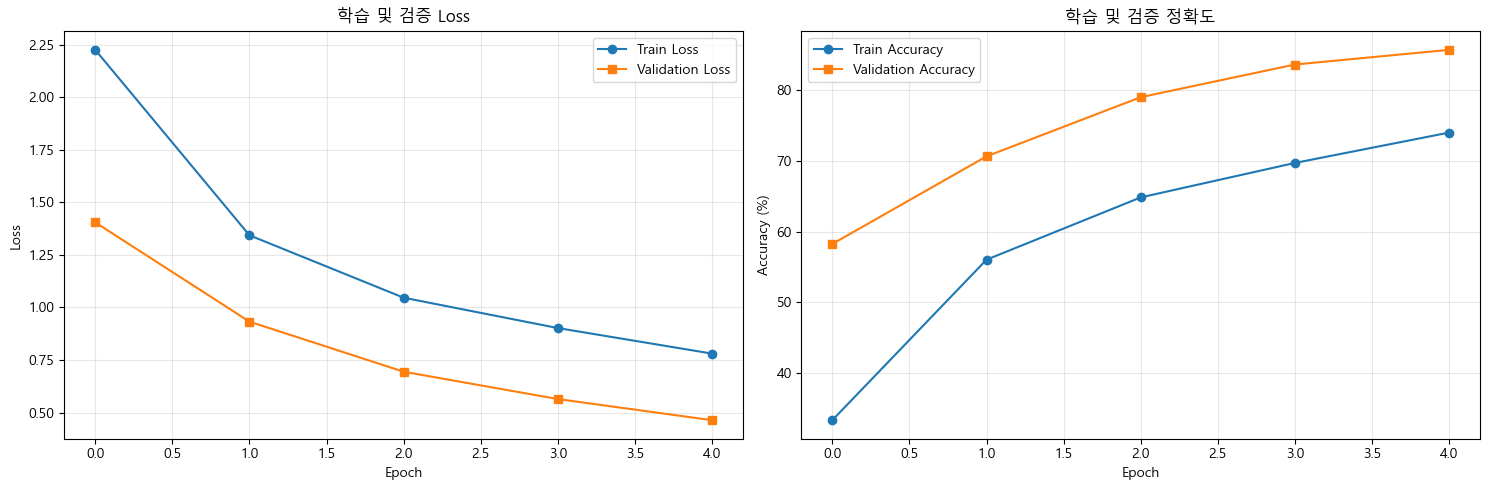

최종 Train Accuracy: 74.03%
최종 Validation Accuracy: 85.74%
Accuracy 차이: 11.71%


In [21]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Validation Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('학습 및 검증 Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o')
axes[1].plot(history['val_acc'], label='Validation Accuracy', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('학습 및 검증 정확도')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'최종 Train Accuracy: {history["train_acc"][-1]:.2f}%')
print(f'최종 Validation Accuracy: {history["val_acc"][-1]:.2f}%')
print(f'Accuracy 차이: {abs(history["train_acc"][-1] - history["val_acc"][-1]):.2f}%')

Confusion Matrix 생성:   0%|          | 0/43 [00:00<?, ?it/s]

C:\Users\user\AppData\Local\Temp\ipykernel_13380\2265623159.py:14: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image = Image.fromarray(pixels.astype(np.uint8), mode='L')


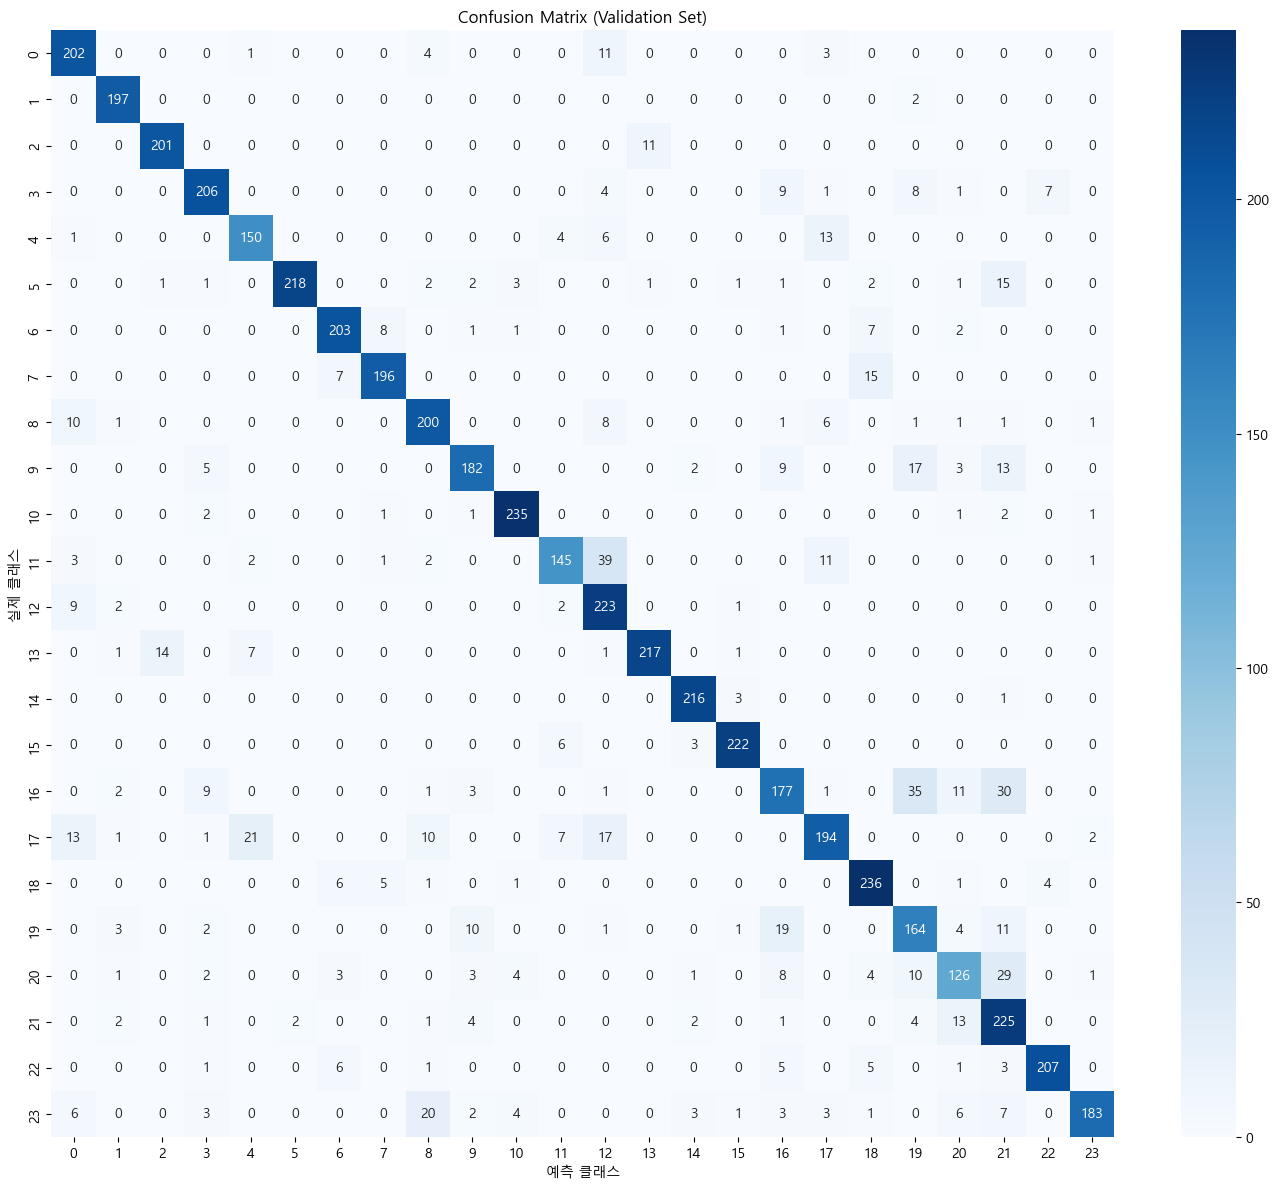

In [22]:
model.load_state_dict(torch.load('./model/best_nnLinear_model.pth'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc='Confusion Matrix 생성'):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('예측 클래스')
plt.ylabel('실제 클래스')
plt.title('Confusion Matrix (Validation Set)')
plt.tight_layout()
plt.show()

## 7. 모델 저장 확인

In [23]:
model_path = './model/best_nnLinear_model.pth'

if os.path.exists(model_path):
    file_size = os.path.getsize(model_path) / (1024 * 1024)
    print(f'✓ 모델 저장 완료')
    print(f'  경로: {model_path}')
    print(f'  크기: {file_size:.2f} MB')
else:
    print('✗ 모델 파일을 찾을 수 없습니다.')

✓ 모델 저장 완료
  경로: ./model/best_nnLinear_model.pth
  크기: 2.19 MB


## 8. 모델 로드 및 테스트 이미지 예측

In [24]:
test_model = ASLLinearNet().to(device)
test_model.load_state_dict(torch.load('./model/best_nnLinear_model.pth'))
test_model.eval()

print('모델 로드 완료')

모델 로드 완료


In [25]:
def predict_image(model, image_path, transform, device):
    if not os.path.exists(image_path):
        print(f'이미지 파일을 찾을 수 없습니다: {image_path}')
        return None, None
    
    image = Image.open(image_path).convert('L')
    image = image.resize((28, 28))
    
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    return predicted.item(), confidence.item()

print('예측 함수 정의 완료')

예측 함수 정의 완료


a.png: 예측 클래스 = 0 (A), 신뢰도 = 87.38%
b.png: 예측 클래스 = 1 (B), 신뢰도 = 96.07%


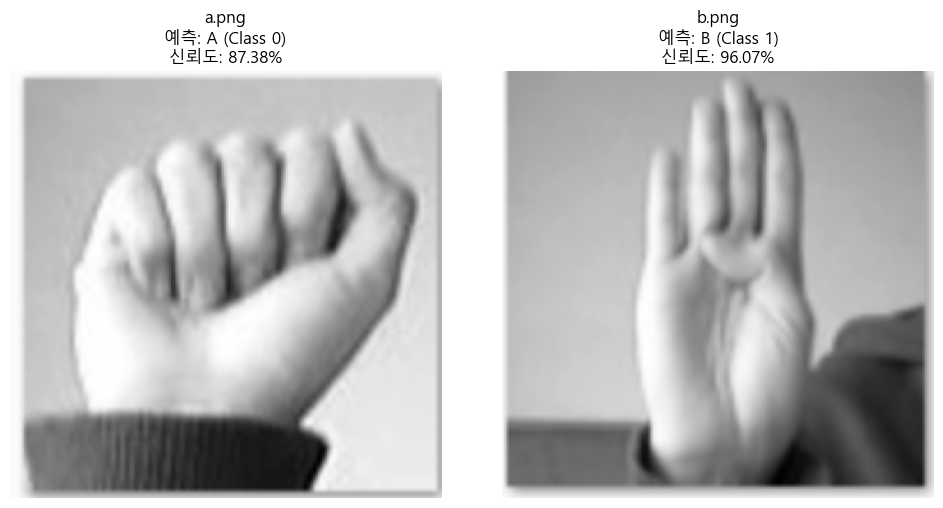

In [29]:
test_images = ['a.png', 'b.png']
label_to_letter = {i: chr(65+i) if i < 9 else chr(65+i+1) for i in range(24)}

fig, axes = plt.subplots(1, len(test_images), figsize=(10, 5))
if len(test_images) == 1:
    axes = [axes]

for idx, img_name in enumerate(test_images):
    img_path = f'./data/asl_image/{img_name}'  # 올바른 경로로 수정
    
    if os.path.exists(img_path):
        predicted_class, confidence = predict_image(test_model, img_path, val_transform, device)
        
        if predicted_class is not None:
            predicted_letter = label_to_letter.get(predicted_class, '?')
            
            image = Image.open(img_path).convert('L')
            axes[idx].imshow(image, cmap='gray')
            axes[idx].set_title(f'{img_name}\n예측: {predicted_letter} (Class {predicted_class})\n신뢰도: {confidence*100:.2f}%')
            axes[idx].axis('off')
            
            print(f'{img_name}: 예측 클래스 = {predicted_class} ({predicted_letter}), 신뢰도 = {confidence*100:.2f}%')
    else:
        axes[idx].text(0.5, 0.5, f'{img_name}\n파일 없음', ha='center', va='center')
        axes[idx].axis('off')
        print(f'{img_name}: 파일을 찾을 수 없습니다.')

plt.tight_layout()
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_13380\2265623159.py:14: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image = Image.fromarray(pixels.astype(np.uint8), mode='L')


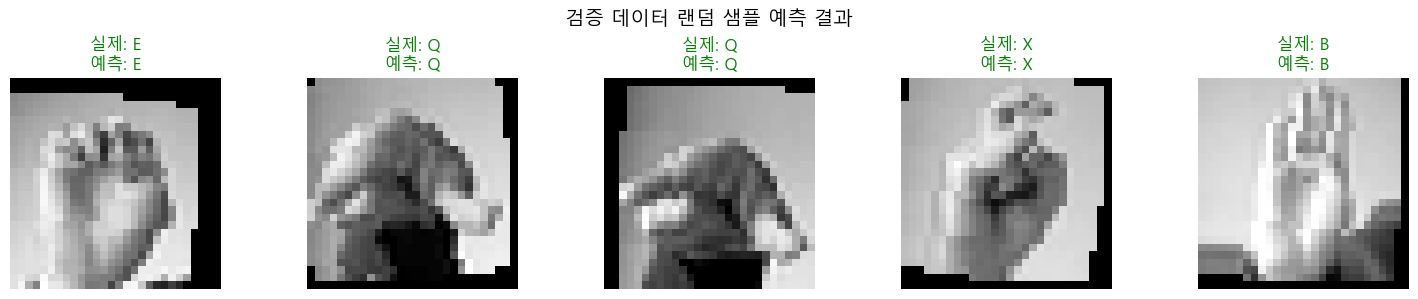

In [30]:
num_samples = 5
indices = np.random.choice(len(val_dataset), num_samples, replace=False)

fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

for i, idx in enumerate(indices):
    image, true_label = val_dataset[idx]
    image_tensor = image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = test_model(image_tensor)
        probabilities = torch.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    predicted_class = predicted.item()
    true_letter = label_to_letter.get(true_label, '?')
    pred_letter = label_to_letter.get(predicted_class, '?')
    
    img_display = image.squeeze().cpu().numpy()
    axes[i].imshow(img_display, cmap='gray')
    
    color = 'green' if predicted_class == true_label else 'red'
    axes[i].set_title(f'실제: {true_letter}\n예측: {pred_letter}', color=color)
    axes[i].axis('off')

plt.suptitle('검증 데이터 랜덤 샘플 예측 결과', fontsize=14)
plt.tight_layout()
plt.show()

## 최종 테스트 성능 평가

In [31]:
test_loss, test_acc = validate_epoch(test_model, test_loader, criterion, device)

print(f'\n=== 최종 테스트 성능 ===')
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.2f}%')
print(f'Best Validation Accuracy: {best_val_acc:.2f}%')

Validation:   0%|          | 0/57 [00:00<?, ?it/s]

C:\Users\user\AppData\Local\Temp\ipykernel_13380\2265623159.py:14: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image = Image.fromarray(pixels.astype(np.uint8), mode='L')



=== 최종 테스트 성능 ===
Test Loss: 0.5192
Test Accuracy: 82.72%
Best Validation Accuracy: 85.74%


## 프로젝트 요약

### 완료된 작업
1. ✓ CSV 데이터 로드 및 탐색
2. ✓ Custom Dataset 클래스 정의 및 데이터 증강
3. ✓ DataLoader 생성
4. ✓ 다층 nn.Linear 모델 정의 (784→512→256→128→24)
5. ✓ 학습 루프 (Train/Validation)
6. ✓ 성능 시각화 및 과적합 분석
7. ✓ 모델 저장 (./model/best_nnLinear_model.pth)
8. ✓ 모델 로드 및 테스트 이미지 예측

### 모델 구조
- **입력층**: 784 (28×28 픽셀)
- **은닉층 1**: 512 (ReLU + BatchNorm + Dropout 0.3)
- **은닉층 2**: 256 (ReLU + BatchNorm + Dropout 0.3)
- **은닉층 3**: 128 (ReLU + BatchNorm + Dropout 0.2)
- **출력층**: 24 (클래스 수)

### 학습 설정
- **Loss**: CrossEntropyLoss
- **Optimizer**: Adam (lr=0.001)
- **Scheduler**: ReduceLROnPlateau
- **Batch Size**: 128
- **Epochs**: 30

### 데이터 증강
- RandomRotation(10도)
- RandomAffine(translate=0.1)
- Normalization (mean=0.5, std=0.5)